

        Welcome to DoDCAE. DoDCAE is a program that extracts data points 
        from over 14,000 Department of Defense (DoD) contracts.The collected
        data enables users to conduct trend analysis of investment, career, 
        and technology trends as they pertain to the DoD. 
        
        To extract contents please provide a date range below. Enjoy.



,Stock Quarters
Q1,1 JAN – 31 MAR
Q2,1 APR – 30 JUN
Q3,1 JUL – 30 SEP
Q4,1 OCT – 31 DEC


Start Format (YYYY-MM-DD): 2022-01-01
End Format (YYYY-MM-DD): 2022-01-31


,Locations,Monetary
3,California,"6,020.2"
23,New York,"3,343.0"
35,Virginia,"3,186.6"
13,Maryland,"1,958.4"
7,Georgia,"1,473.2"
24,North Carolina,"1,024.0"
5,Connecticut,889.7
21,New Jersey,616.9
6,Florida,541.6
33,Texas,479.3


,visited_links
0,https://www.defense.gov/News/Contracts/Contract/Article/2918328/
1,https://www.defense.gov/News/Contracts/Contract/Article/2916618/
2,https://www.defense.gov/News/Contracts/Contract/Article/2914949/
3,https://www.defense.gov/News/Contracts/Contract/Article/2913552/
4,https://www.defense.gov/News/Contracts/Contract/Article/2911544/
5,https://www.defense.gov/News/Contracts/Contract/Article/2909723/
6,https://www.defense.gov/News/Contracts/Contract/Article/2907867/
7,https://www.defense.gov/News/Contracts/Contract/Article/2906241/
8,https://www.defense.gov/News/Contracts/Contract/Article/2904544/
9,https://www.defense.gov/News/Contracts/Contract/Article/2903045/


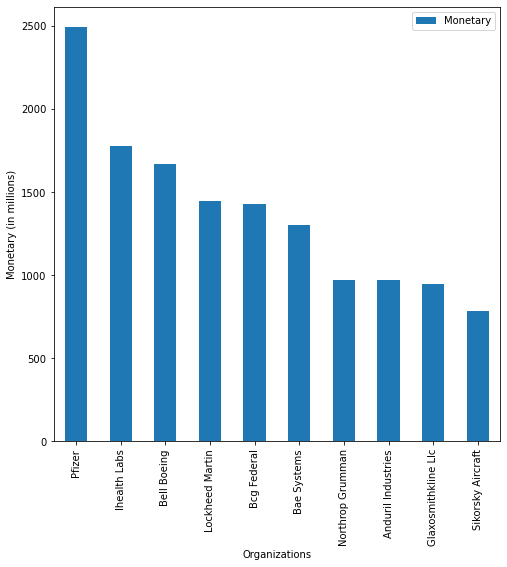

In [1]:
#!/usr/bin/env python3
# coding: utf-8
import requests
import re
import pandas as pd
import openpyxl
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from os import listdir, system
from openpyxl import load_workbook

def dodcae():
    
    ## Scraper function that grabs all links on a webpages contents.
    
    def backdated_links():
        links = []
        print()
        intro = '''
        Welcome to DoDCAE. DoDCAE is a program that extracts data points 
        from over 14,000 Department of Defense (DoD) contracts.The collected
        data enables users to conduct trend analysis of investment, career, 
        and technology trends as they pertain to the DoD. 
        
        To extract contents please provide a date range below. Enjoy.'''
        print(intro)
        print()
        stock_quarters = pd.DataFrame(["1 JAN – 31 MAR","1 APR – 30 JUN","1 JUL – 30 SEP","1 OCT – 31 DEC"])
        stock_quarters.columns = ['Stock Quarters']
        stock_quarters.index = ['Q1', 'Q2', 'Q3', 'Q4']
        display(stock_quarters)
        print()
        backdate_url = f'https://www.defense.gov/News/Contracts/StartDate/{input ("Start Format (YYYY-MM-DD):")}/EndDate/{input ("End Format (YYYY-MM-DD):")}/'
        print()
        backdate_urlcheck = re.findall(r'https://www.defense.gov/News/Contracts/StartDate/[0-9]{4}-[0-9]{2}-[0-9]{2}/EndDate/[0-9]{4}-[0-9]{2}-[0-9]{2}/', (backdate_url))
        if backdate_url == backdate_urlcheck[0]:
            backdate_url = backdate_urlcheck[0]
            
        page_links = []
        page_links.append(backdate_url)
        i = 2
        while i!=0:
            template = f'?Page={i}'
            url = backdate_url + template
            search = requests.get(url)
            search = BeautifulSoup(search.text, "html.parser")
            search = str(search.find_all('listing-titles-only'))
            search_links = re.findall(r'http://www.defense.gov/News/Contracts/Contract/Article/[0-9]{7,7}/', (search))
            if len(search_links) > 0:
                i = i+1
                page_links.append(url)
            elif len(search_links) == 0:
                i = 0
                
        links, findlinks = [], []
        for x in page_links:
            link = requests.get(x)
            link = BeautifulSoup(link.text, "html.parser")
            link = str(link.find_all('listing-titles-only'))
            findlinks = re.findall(r'http://www.defense.gov/News/Contracts/Contract/Article/[0-9]{7,7}/', (link))
            [links.append(str) for str in findlinks if str not in links]
            links = ([str.replace("http", "https") for str in links])
            links = ([str.replace("httpss", "https") for str in links])
            
        return links
    
    #Data parser       
    def backdate():
        links = backdated_links()
        for x in links:
            def results_collection():
                res = requests.get(x)
                soup2 = BeautifulSoup(res.text, "html.parser")
                for match in soup2.find_all('span'):
                    match.unwrap()
                for match in soup2.find_all('a'):
                    match.unwrap()
                for p in soup2.find_all('p'):
                    if 'style' in p.attrs:
                        del p.attrs['style']
                for p in soup2.find_all('p'):
                    if 'class' in p.attrs:
                        del p.attrs['class']
                results = soup2.find('div', attrs={'class':'body'}).find_all("p") #Article content HTML location
                return results
            results = results_collection()
            
            def visited_links():
                pd.set_option('display.max_colwidth', None)
                visited_links = [x for x in links]
                df_links = pd.DataFrame()
                df_links['visited_links'] = visited_links
                return df_links

            #Paragraph collection
            paragraphs = [str(x) for x in results]

            #Monetary Amounts of each paragraph. 
            monetary, organizations, locations = [], [], []
            for x in paragraphs:
                amount = re.findall(r'(\$\d+\,\d{3}\,\d{3}\,?\d{0,3})', (x))
                monetary.append(str(amount[0:1]))
                monetary_dic = {'$':'',',':'','\'':'','[':'',']':''}
                for key, value in monetary_dic.items():
                    monetary = ([str.replace(key, value) for str in monetary])
            #Organizations collection.
                org_name = re.findall(r'^(.+?),', (x))
                organizations.append(str(org_name))
                organizations_dic = {'<p>':'','\'':'','[':'',']':'','&amp':'','The':'','Inc':'',';':'','.':'','"':''}
                for key, value in organizations_dic.items():
                    organizations = ([str.replace(key, value) for str in organizations])
            #Locations collection.
                loc = re.findall(r'(Alabama|Alaska|Arizona|Arkansas|Australia|California|Colorado|Connecticut|Delaware|Florida|Georgia|Hawaii|Idaho|Illinois|Indiana|Iowa|Kansas|Kentucky|Louisiana|Maine|Maryland|Massachusetts|Michigan|Minnesota|Mississippi|Missouri|Montana|Nebraska|Nevada|New Hampshire|New Jersey|New Mexico|New York|North Carolina|North Dakota|Ohio|Oklahoma|Oregon|Pennsylvania|Puerto Rico|Rhode Island|South Carolina|South Dakota|Tennessee|Texas|Utah|Vermont|Virginia|Washington|West Virginia|Wisconsin|Wyoming/)', (x))
                locations.append(str(loc[0:1]))
                locations_dic = {'\'':'','[':'',']':''}
                for key, value in locations_dic.items():
                    locations = ([str.replace(key, value) for str in locations])    
                    
            ## Creating 3 different dataframes that will be exported to a sole excel file.        
            def organization_funds():
                max_size=2
                df_orgfunds = pd.DataFrame()
                df_orgfunds['Organizations'] = organizations
                df_orgfunds['Monetary'] = monetary
                df_orgfunds['Monetary'].replace('', np.nan, inplace=True)
                df_orgfunds['Organizations'].replace('', np.nan, inplace=True)
                df_orgfunds.dropna(how='any', inplace = True)
                df_orgfunds['Monetary'] = df_orgfunds['Monetary'].astype(int)
                df_orgfunds['Organizations'] =  df_orgfunds['Organizations'].map(str)
                df_orgfunds['Organizations'] = df_orgfunds['Organizations'].str.upper().str.title()
                df_orgfunds['Organizations'] = df_orgfunds['Organizations'].apply(lambda x: ' '.join(x.split(maxsplit=max_size)[:max_size]))
                df_orgfunds.Monetary = np.where( df_orgfunds.Monetary > 0, df_orgfunds.Monetary/ 1000000, df_orgfunds.Monetary)
                df_orgfunds = df_orgfunds.groupby('Organizations', as_index=False).agg({'Monetary':sum})
                pd.options.display.float_format = "{:,.1f}".format
                return df_orgfunds

            def location_funds():
                df_locationfunds = pd.DataFrame()
                df_locationfunds['Locations'] = locations
                df_locationfunds['Monetary'] = monetary
                df_locationfunds['Monetary'].replace('', np.nan, inplace=True)
                df_locationfunds['Locations'].replace('', np.nan, inplace=True)
                df_locationfunds.dropna(how='any', inplace = True)
                df_locationfunds['Monetary'] = df_locationfunds['Monetary'].astype(int)
                df_locationfunds.Monetary = np.where(df_locationfunds.Monetary > 7500000, df_locationfunds.Monetary/ 1000000, df_locationfunds.Monetary)
                df_locationfunds = df_locationfunds.groupby('Locations', as_index=False).agg({'Monetary':sum})
                return df_locationfunds

            def buildxlsx():
                pd.set_option('display.max_colwidth', None)
                df_locationfunds, df_orgfunds, df_links = location_funds(), organization_funds(), visited_links()
                dflist = [df_orgfunds, df_locationfunds, df_links]
                writer = pd.ExcelWriter("DefenseContracts_Data_Backdate.xlsx", engine = "openpyxl")
                for i, df in enumerate (dflist):
                        df.to_excel(writer, sheet_name="Sheet" + str(i+1), index=False)
                writer.save()

            def readcurrentxlsx():
                Sheet1 = pd.read_excel("DefenseContracts_Data_Backdate.xlsx", sheet_name="Sheet1", engine="openpyxl")
                Sheet2 = pd.read_excel("DefenseContracts_Data_Backdate.xlsx",sheet_name="Sheet2", engine="openpyxl")
                Sheet3 = pd.read_excel("DefenseContracts_Data_Backdate.xlsx",sheet_name="Sheet3", engine="openpyxl")
                return Sheet1, Sheet2, Sheet3

            def buildoncurrentxlsx():
                df_locationfunds, df_orgfunds, df_links = location_funds(), organization_funds(), visited_links()
                pd.set_option('display.max_colwidth', None)
                pd.options.display.float_format = "{:,.1f}".format
                Sheet1, Sheet2, Sheet3 = readcurrentxlsx()
                book = load_workbook("DefenseContracts_Data_Backdate.xlsx")
                writer = pd.ExcelWriter("DefenseContracts_Data_Backdate.xlsx", engine='openpyxl') 
                writer.book = book
                writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
                df_orgfunds = df_orgfunds.append(Sheet1)
                df_locationfunds = df_locationfunds.append(Sheet2)
                df_links = df_links.append(Sheet3)
                df_links = df_links.drop_duplicates()
                df_orgfunds = df_orgfunds.groupby('Organizations', as_index=False).agg({'Monetary':sum})
                df_locationfunds = df_locationfunds.groupby('Locations', as_index=False).agg({'Monetary':sum})
                #Appending new contract data.
                dflist = [df_orgfunds, df_locationfunds,df_links]
                for i, df in enumerate (dflist):
                        df.to_excel(writer, sheet_name="Sheet" + str(i+1), index=False)
                writer.save()

            if os.path.isfile('./DefenseContracts_Data_Backdate.xlsx')==False:
                buildxlsx()
            else: 
                buildoncurrentxlsx()
                
    ## Display all output
    
    def displayoutput():
        Sheet1 = pd.read_excel("DefenseContracts_Data_Backdate.xlsx", sheet_name="Sheet1", engine="openpyxl")
        Sheet1.sort_values('Monetary', ascending=False)[['Organizations','Monetary']].head(10).plot.bar(style='dict', ylabel='Monetary (in millions)', fontsize=10, 
       figsize=(8,8), x='Organizations', y='Monetary')
        
        Sheet2 = pd.read_excel("DefenseContracts_Data_Backdate.xlsx",sheet_name="Sheet2", engine="openpyxl")
        Sheet2 = Sheet2.sort_values('Monetary', ascending=False)[['Locations','Monetary']].head(10)
        
        Sheet3 = pd.read_excel("DefenseContracts_Data_Backdate.xlsx",sheet_name="Sheet3", engine="openpyxl")
        display(Sheet2, Sheet3.head(10))
          
    backdate()
    displayoutput()
    
## Run DoDCAE
dodcae()